In [1]:
use_gpu = False

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')

if use_gpu:
    from utils.gpu_tools import *
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([ str(obj) for obj in select_gpu(query_gpu())])

os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

## load data

In [52]:
year_list = np.arange(2018,2020,1)
print(year_list)

[2018 2019]


In [53]:
images = []
label_df = []
for year in year_list:
    images.append(np.memmap(os.path.join("monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

(137118, 64, 60)
(137118, 8)


In [54]:
label_df

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,2018-01-31,10026,2585782.25,-0.026726,-0.028459,0.007880,-0.029687,0.000431
1,2018-02-28,10026,2509015.75,0.052111,0.005406,0.036924,0.019895,0.000273
2,2018-03-29,10026,2553262.25,0.014059,0.018455,0.136837,0.006226,0.000184
3,2018-04-30,10026,2569841.75,-0.017175,0.019576,0.124034,0.030637,0.000129
4,2018-05-31,10026,2648577.25,0.032128,0.086302,0.015476,0.079857,0.000183
...,...,...,...,...,...,...,...,...
68632,2019-08-30,93436,40412844.00,0.027392,0.067639,0.490805,0.067639,0.000867
68633,2019-09-30,93436,43356600.00,-0.013078,0.360527,0.765477,0.307429,0.000920
68634,2019-10-31,93436,56762756.00,0.065478,0.047695,0.844879,0.047695,0.002130
68635,2019-11-29,93436,59470036.00,0.018034,0.256895,1.057951,0.267897,0.001075


In [55]:
images[0]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 255,   0, ...,   0, 255,   0],
       [  0, 255,   0, ...,   0, 255,   0],
       [  0, 255,   0, ...,   0, 255,   0]], dtype=uint8)

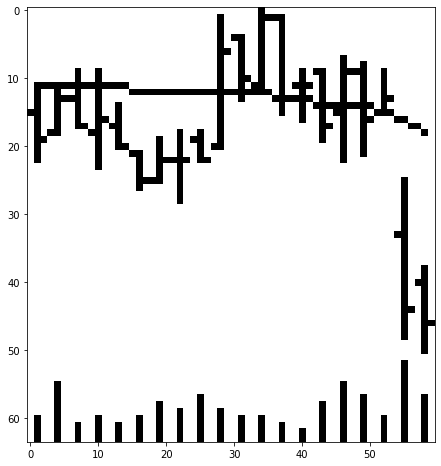

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.imshow(images[0],cmap=plt.cm.binary)

## build dataset

In [56]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [57]:
dataset = MyDataset(images, (label_df.Ret_20d > 0).values)

In [58]:
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

# the neural network

In [59]:
net_path = 'pt/20220420_223931/baseline_epoch_17_train_0.705977_val_0.701302.pt'

In [60]:
from models import baseline
device = 'cuda' if use_gpu else 'cpu'

In [61]:
net = torch.load(net_path)

## test

In [62]:
def eval_loop(dataloader, net, loss_fn):
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)

In [63]:
loss_fn = nn.CrossEntropyLoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:,1]).cpu().numpy()

100%|██████████| 67/67 [29:26<00:00, 26.36s/it, running_loss=0.73] 


In [70]:
import loadAndRead
loadAndRead.write(y_pred,'y_pred.pkl')
loadAndRead.write(predict_logit,'predict_logit.pkl')
# predict_logit = loadAndRead.read('predict_logit.pkl')

In [80]:
y_target

tensor([0., 1., 1.,  ..., 1., 1., 1.])

In [103]:
(y_pred[:,1])

tensor([ 0.1174, -0.0957,  0.4281,  ..., -0.3423,  0.2145, -0.2615])

In [95]:
(predict_logit>0.58)

array([ True,  True,  True, ...,  True,  True,  True])

In [66]:
predict_logit

array([0.6689763 , 0.6619671 , 0.7797623 , ..., 0.62037796, 0.69662106,
       0.66742975], dtype=float32)

In [89]:
from sklearn.metrics import classification_report

In [105]:
# print(classification_report(y_target,(y_pred[:,1]>0)))
print(classification_report(y_target,(predict_logit>0.50),digits=4))

              precision    recall  f1-score   support

         0.0     0.4977    0.2395    0.3234     67386
         1.0     0.5105    0.7663    0.6128     69732

    accuracy                         0.5074    137118
   macro avg     0.5041    0.5029    0.4681    137118
weighted avg     0.5042    0.5074    0.4706    137118



## Plot the performance

In [13]:
from matplotlib import pyplot as plt

### Same Weighted

In [14]:
threshold = 0.

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_baseline = label_filtered .groupby(['Date'])['Ret_20d'].mean()

threshold = 0.58

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_cnn = label_filtered .groupby(['Date'])['Ret_20d'].mean()


### Compare of log accumulate return

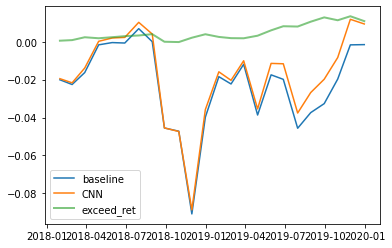

In [16]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
fig = plt.figure()
plt.plot(log_ret_baseline, label='baseline')
plt.plot(log_ret_cnn, label='CNN')
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2, label='exceed_ret')
plt.legend()
plt.show()
fig.savefig('pic/performance1.png',dpi=300)


## Grad_CAM
pip install grad-cam

library is from https://github.com/jacobgil/pytorch-grad-cam

In [106]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

18098,18113,18114

In [624]:
i = 26

In [625]:
y_target[i]

tensor(0.)

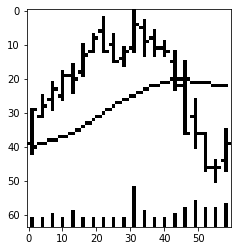

In [626]:
plt.imshow(images[i],cmap=plt.cm.binary)
# plt.savefig('output.jpg')
plt.show()

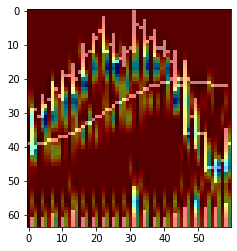

In [630]:
target_layers = [net.layer1[-1]]
input_tensor = dataset.img[i,:]
cam = GradCAM(model=net,target_layers=target_layers)
# targets = [ClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=input_tensor, targets=None)
grayscale_cam = grayscale_cam[0, :]

bgr_img = cv2.cvtColor((np.float32(images[i])/255),cv2.COLOR_GRAY2BGR)

visualization = show_cam_on_image(bgr_img, grayscale_cam)

plt.imshow(visualization)
# plt.imshow(cv2.cvtColor(visualization,cv2.COLOR_BGR2GRAY))
plt.show()